## Feature Selection in Machine Learning
We will be looking at the Friedman dataset from the sklearn library. It is a popular dataset used to compare feature selection methods for machine learning algorithms.

### Step 1: Defining a class for the problem

In [171]:
%matplotlib notebook

In [172]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import numpy as np

In [173]:
class Problem:
    
    def __init__(self,num_samples,num_features,noise,random_seed,test_split):
        
        self.num_samples = num_samples
        self.num_features = num_features
        self.noise = noise
        self.random_seed = random_seed
        self.test_split = test_split
        
        
        self.X, self.Y = datasets.make_friedman1(n_samples=self.num_samples,n_features=self.num_features,
                                                 noise=self.noise,random_state=self.random_seed)
        self.X_train, self.X_validation, self.Y_train, self.Y_validation = model_selection.train_test_split(self.X,self.Y,
                                                                    test_size = self.test_split,random_state=self.random_seed)
        
        self.regressor = ensemble.GradientBoostingRegressor(random_state=self.random_seed)
    
    def get_MSE(self,binary_list):
        
        zeroIndices = [i for i,n in enumerate(binary_list) if n==0]
        currentX_train = np.delete(self.X_train, zeroIndices, 1)
        currentX_validation = np.delete(self.X_validation, zeroIndices, 1)
        
        self.regressor.fit(currentX_train,self.Y_train)
        
        predictions = self.regressor.predict(currentX_validation)
        
        return metrics.mean_squared_error(self.Y_validation,predictions)

### Step 2: Problem representation and Parameters of Genetic algorithm

In [174]:
import random
from deap import tools
from deap import base
from deap import creator
import elitism
import seaborn as sns
import matplotlib.pyplot as plt

In [175]:
POPULATION_SIZE = 30
P_CROSSOVER = 0.9
P_MUTATION = 0.3
MAX_GENERATIONS = 30
HALL_OF_FAME_SIZE = 5
NUM_SAMPLES = 60
NUM_FEATURES = 15
NOISE = 1.0
TEST_SPLIT = 0.2
RANDOM_SEED = 42

In [177]:
creator.create("FitnessMin",base.Fitness,weights=(-1.0,))
creator.create("individual",list,fitness = creator.FitnessMin)

In [178]:
friedman = Problem(NUM_SAMPLES,NUM_FEATURES,NOISE,RANDOM_SEED,TEST_SPLIT)

toolbox = base.Toolbox()

toolbox.register("zeroOrone",random.randint,0,1)

toolbox.register("individualCreator",tools.initRepeat,creator.individual,toolbox.zeroOrone,NUM_FEATURES)
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

toolbox.register("select",tools.selTournament,tournsize=2)
toolbox.register("mate",tools.cxTwoPoint)
toolbox.register("mutate",tools.mutFlipBit,indpb=1.0/NUM_FEATURES)

def get_MSE(individual):
    return friedman.get_MSE(individual),

toolbox.register("evaluate",get_MSE)

### Step 3: Genetic algorithm flow

gen	nevals	min    	avg    
0  	30    	12.7544	26.1921
1  	25    	11.8079	22.708 
2  	24    	10.1829	18.4808
3  	20    	9.81846	17.1192
4  	22    	7.91068	13.7718
5  	25    	7.32259	12.6507
6  	20    	7.32259	10.6879
7  	22    	6.70267	9.97272
8  	21    	6.70267	9.0332 
9  	22    	6.70267	8.37257
10 	22    	6.70267	8.2486 
11 	24    	6.70267	8.82156
12 	20    	6.70267	8.06919
13 	24    	6.70267	8.29953
14 	22    	6.70267	7.80196
15 	25    	6.70267	8.51589
16 	21    	6.70267	8.19476
17 	23    	6.70267	7.71553
18 	23    	6.70267	7.64838
19 	23    	6.70267	7.73486
20 	24    	6.70267	8.38011
21 	20    	6.70267	8.03253
22 	23    	6.70267	7.25296
23 	23    	6.70267	7.89231
24 	23    	6.70267	7.57849
25 	24    	6.70267	7.26152
26 	22    	6.70267	7.32372
27 	24    	6.70267	7.92787
28 	24    	6.70267	7.73693
29 	24    	6.70267	8.19217
30 	21    	6.70267	7.21841
-- Best Ever Individual =  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
-- Best Ever Fitness =  6.702668910463276


<IPython.core.display.Javascript object>


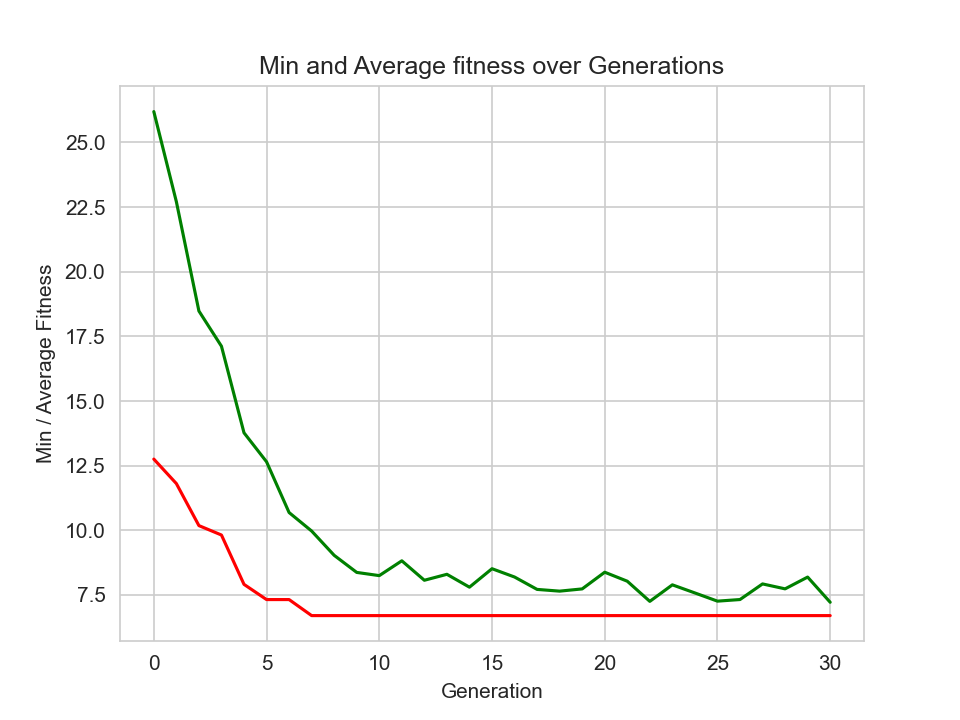

In [180]:
population = toolbox.populationCreator(POPULATION_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("min", np.min)
stats.register("avg", np.mean)

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')
plt.show()